## Importando os pacotes

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import glob
import os
import h5py

from sklearn.preprocessing import minmax_scale
from skimage import img_as_ubyte
from skimage.transform import resize 
from sklearn.metrics import confusion_matrix, accuracy_score, cohen_kappa_score
from sklearn.model_selection import train_test_split

from keras.layers import Conv3D, MaxPool3D, Flatten, Dense
from keras.layers import Dropout, Input, BatchNormalization
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta
from keras.models import load_model
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2
from keras import regularizers

import tensorflow as tf

## Converter uint8

In [4]:
def scaler_uint8(image):
    shape = image.shape
    image_scaled = minmax_scale(image.ravel(), feature_range=(0,255)).reshape(shape).astype(np.uint8)
    return image_scaled

# Lendo a base .npy

In [5]:
def lendo_img_npy(paths):
    slices = [resize(np.load(s), (16, 16, 16, 1), preserve_range=True) for s in paths] 
    return scaler_uint8(np.array(slices))

# Lendo imagens (treino) - Nódulos ->  Benigno e Maligno

In [6]:
def lendo_conjunto_all(path_benigno, path_maligno):
    # Benigno
    path_b = glob.glob(path_benigno)
    images_b_npy = lendo_img_npy(path_b)
    # Maligno 
    path_m = glob.glob(path_maligno)
    images_m_npy = lendo_img_npy(path_m)
    return(images_b_npy, images_m_npy)
    

# Lendo imagens - Nódulos ->  Benigno e Maligno

In [8]:
path_treino_b = '../../new_dataset_uint8/treino/benigno/*.npy'
path_valid_b = '../../new_dataset_uint8/valid/benigno/*.npy'
path_teste_b = '../../new_dataset_uint8/teste/benigno/*.npy'

path_treino_m = '../../new_dataset_uint8/treino/maligno/*.npy'
path_valid_m = '../../new_dataset_uint8/valid/maligno/*.npy'
path_teste_m = '../../new_dataset_uint8/teste/maligno/*.npy'

treino_benigno, treino_maligno = lendo_conjunto_all(path_treino_b, path_treino_m)
valid_benigno, valid_maligno = lendo_conjunto_all(path_valid_b, path_valid_m)
teste_benigno, teste_maligno = lendo_conjunto_all(path_teste_b, path_teste_m)

## Image Type 

In [9]:
image = teste_benigno[0].copy()
print('Type: ', image.dtype)
print('Max: ', np.amax(image))
print('Min: ', np.amin(image))
    

Type:  uint8
Max:  253
Min:  0


# Gerando os labels (Treino)

In [10]:
labels_treino_0 = np.zeros((treino_benigno.shape[0])).astype(np.int)
print('Treino Benigno: ', len(labels_treino_0))
labels_treino_1 = np.ones((treino_maligno.shape[0])).astype(np.int)
print('Treino Maligno: ', len(labels_treino_1))
labels_treino = np.concatenate((labels_treino_0, labels_treino_1))
print('Tamanho do conjunto de treino:', len(labels_treino))

Treino Benigno:  668
Treino Maligno:  271
Tamanho do conjunto de treino: 939


# Gerando os labels (Validação)

In [11]:
labels_val_0 = np.zeros((valid_benigno.shape[0])).astype(np.int)
print('Validação Benigno : ', len(labels_val_0))
labels_val_1 = np.ones((valid_maligno.shape[0])).astype(np.int)
print('Validação Maligno : ', len(labels_val_1))
labels_valid = np.concatenate((labels_val_0, labels_val_1))
print('Tamanho do conjunto de validação:', len(labels_valid))

Validação Benigno :  96
Validação Maligno :  39
Tamanho do conjunto de validação: 135


# Gerando os labels (Teste)

In [12]:
labels_teste_0 = np.zeros((teste_benigno.shape[0])).astype(np.int)
print('Teste Benigno : ', len(labels_teste_0))
labels_teste_1 = np.ones((teste_maligno.shape[0])).astype(np.int)
print('Teste Maligno : ', len(labels_teste_1))
labels_teste = np.concatenate((labels_teste_0, labels_teste_1))
print('Tamanho do conjunto de teste:', len(labels_teste))

Teste Benigno :  192
Teste Maligno :  79
Tamanho do conjunto de teste: 271


# Concatenar (Treino e Teste)

In [13]:
base_train = np.concatenate((treino_benigno, treino_maligno))
print('Shape das imagens de treino concatenada:', base_train.shape)

base_valid = np.concatenate((valid_benigno, valid_maligno))
print('Shape das imagens de validação concatenada:', base_valid.shape)

base_teste = np.concatenate((teste_benigno, teste_maligno))
print('Shape das imagens de teste concatenada:', base_teste.shape)

Shape das imagens de treino concatenada: (939, 16, 16, 16, 1)
Shape das imagens de validação concatenada: (135, 16, 16, 16, 1)
Shape das imagens de teste concatenada: (271, 16, 16, 16, 1)


# Embaralhar conjunto (Treino e Teste)

In [14]:
treino1, treino2 , labels_treino1, labels_treino2 = train_test_split(base_train, labels_treino, test_size = 0.5, random_state=42)
x_train = np.concatenate((treino1, treino2))
y_train = np.concatenate((labels_treino1, labels_treino2))
print(x_train.shape)

(939, 16, 16, 16, 1)


In [15]:
valid1, valid2 , labels_valid1, labels_valid2 = train_test_split(base_valid, labels_valid, test_size = 0.5, random_state=42)
x_valid = np.concatenate((valid1, valid2))
y_valid = np.concatenate((labels_valid1, labels_valid2))
print(x_valid.shape)

(135, 16, 16, 16, 1)


In [16]:
teste1, teste2 , labels_teste1, labels_teste2 = train_test_split(base_teste, labels_teste, test_size = 0.5, random_state=42)
x_test = np.concatenate((teste1, teste2))
y_test = np.concatenate((labels_teste1, labels_teste2))
print(x_test.shape)

(271, 16, 16, 16, 1)


## Normalização (Treino, Validação e Teste)

In [17]:
x_train = x_train / 255.
x_valid = x_valid / 255.
x_test = x_test / 255.

## Imagens normalizadas

In [18]:
image = x_test[4].copy()
print('Type: ', image.dtype)
print('Max: ', np.amax(image))
print('Min: ', np.amin(image))

Type:  float64
Max:  0.996078431372549
Min:  0.0


# Convert target variable into one-hot

In [19]:
y_train = to_categorical(y_train, 2)
y_valid = to_categorical(y_valid, 2)
y_test = to_categorical(y_test, 2)

# Selected GPU

In [20]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";  # The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";  # Do other imports now...

## Camada de Entrada

In [ ]:
# input layer
img_input = Input((16, 16, 16, 1))

x = Conv3D(8, (3, 3 ,3), activation='relu', padding='same', name='block1_conv1', kernel_regularizer=regularizers.l2(0.0001))(img_input)
x = Conv3D(16, (3, 3 ,3), activation='relu', padding='same', name='block1_conv2', kernel_regularizer=regularizers.l2(0.0001))(x)
x = MaxPool3D((2, 2, 2), strides=(2, 2, 2), name='block1_pool')(x)

pooling_layer2 = BatchNormalization()(x)
flatten_layer = Flatten()(pooling_layer2)

dense_layer1 = Dense(units=256, activation='relu', name='fc1', kernel_regularizer=regularizers.l2(0.0001))(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu', name='fc2', kernel_regularizer=regularizers.l2(0.0001))(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
##Informar a quantidade de categoria 
output_layer = Dense(units=2, activation='softmax', name='predictions')(dense_layer2)

## define o modelo com a camada de entrada e a de saída
model = Model(inputs=img_input, outputs=output_layer) 

In [ ]:
model.summary()

## Treinando o modelo 

In [ ]:
checkpoint = ModelCheckpoint("best_model_ISBI_Teste1_LR_001_5000.h5", monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

model.compile(loss=categorical_crossentropy, optimizer=Adadelta(lr=0.001, decay=0.0001), metrics=['acc'])

hist = model.fit(x=x_train, 
                 y=y_train,  
                 batch_size=128, 
                 epochs=5000,  
                 validation_data=(x_valid, y_valid), 
                 callbacks=[checkpoint])
model.save("model_ISBI_Teste1_LR_001_5000.h5")
np.save('./history_model_ISBI_Teste1_LR_001_5000', hist)

## Predição

In [41]:
def accuracy(x, y, modelo, name):
    print('\n', name)
    pred = modelo.predict(x)
    pred = np.argmax(pred, axis=1)
    real = np.argmax(y, axis=1)
    print('Matriz de confusão:\n', confusion_matrix(real, pred))
    print('Acurácia:', accuracy_score(real, pred))
    print('Kappa: ', cohen_kappa_score(real, pred))
    
# accuracy(x_train, y_train, model, 'Treino:')
# accuracy(x_valid, y_valid, model, 'Validação:')
# accuracy(x_test, y_test, model, 'Teste:')

## Todas as méticas 

In [50]:
def calc_metric(x, y, modelo):
    #print(y_pred.shape,y_true.shape,np.unique(y_pred),np.unique(y_true))
    pred = modelo.predict(x)
    y_pred = np.argmax(pred, axis=1)
    y_true = np.argmax(y, axis=1)
    cm = confusion_matrix(y_pred.ravel(),y_true.ravel())
    # tn -> Verdeiro Negativo
    # fp -> Falso Positivo
    # fn -> Falso Negativo
    # tp -> Verdadeiro Positivo
    tn, fp, fn, tp = cm.ravel()
    dice = (2.0 * tp) / ((2.0 * tp) + fp + fn)
    jaccard = (1.0 * tp) / (tp + fp + fn)
    sensitivity = (1.0 * tp) / (tp + fn)
    specificity = (1.0 * tn) / (tn + fp)
    accuracy = (1.0 * (tn + tp)) / (tn + fp + tp + fn)
    auc = 1 - 0.5 * (((1.0 * fp) / (fp + tn)) + ((1.0 * fn) / (fn + tp)))
    prec = float(tp)/float(tp + fp)
    fscore = float(2*tp)/float(2*tp + fp + fn)
    kappa = cohen_kappa_score(y_pred, y_true)
    return accuracy, kappa, sensitivity, specificity, auc

# Realizando a predição


In [46]:
def predict_model(url_model):
    pred_model = load_model(url_model)
    print('\n-------------- Validação ------------------')
    score = pred_model.evaluate(x_valid, y_valid, verbose=0)
    print('loss:', score[0])
    accuracy, kappa, sensitivity, specificity, auc = calc_metric(x_valid, y_valid, pred_model)
    print('accuracy: ', accuracy)
    print('kappa: ', kappa)
    print('sensitivity: ', sensitivity)
    print('specificity: ', specificity)
    print('auc: ', auc)
    
    print('\n-------------- Teste ------------------')
    pred_model = load_model(url_model)
    score = pred_model.evaluate(x_test, y_test, verbose=0)
    print('loss:', score[0])
    accuracy, kappa, sensitivity, specificity, auc = calc_metric(x_test, y_test, pred_model)
    print('accuracy: ', accuracy)
    print('kappa: ', kappa)
    print('sensitivity: ', sensitivity)
    print('specificity: ', specificity)
    print('auc: ', auc)  

In [47]:
print('Melhor Modelo:')
predict_model("best_model_ISBI_Teste1_LR_001_5000.h5")
print('Modelo Final:')
predict_model("model_ISBI_Teste1_LR_001_5000.h5")

Melhor Modelo:

-------------- Validação ------------------
loss: 0.34714615609910754
accuracy:  0.8888888888888888
kappa:  0.6998666073810582
sensitivity:  0.9615384615384616
specificity:  0.8715596330275229
auc:  0.9165490472829922

-------------- Teste ------------------
loss: 0.3980402516482941
accuracy:  0.8634686346863468
kappa:  0.673121434392828
sensitivity:  0.7560975609756098
specificity:  0.91005291005291
auc:  0.8330752355142599
Modelo Final:

-------------- Validação ------------------
loss: 0.3659856897813302
accuracy:  0.8888888888888888
kappa:  0.6998666073810582
sensitivity:  0.9615384615384616
specificity:  0.8715596330275229
auc:  0.9165490472829922

-------------- Teste ------------------
loss: 0.43539909045194786
accuracy:  0.8671586715867159
kappa:  0.6784018987341772
sensitivity:  0.7721518987341772
specificity:  0.90625
auc:  0.8392009493670887


# Plotando os gráfico (history), Acurácia e Erro (Treino e Validação)

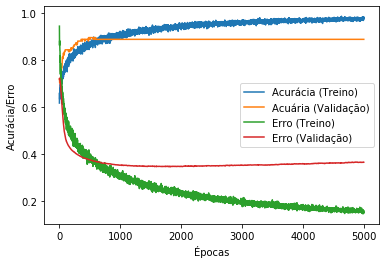

In [48]:
def plot_history(hist):
    plt.plot(hist.history["acc"])
    plt.plot(hist.history['val_acc'])
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
#     plt.title("model accuracy")
    plt.ylabel("Acurácia/Erro")
    plt.xlabel("Épocas")
    plt.legend(["Acurácia (Treino)","Acuária (Validação)","Erro (Treino)","Erro (Validação)"])
    plt.savefig('ISBI_Teste1_LR_001_5000.png')
    plt.show()
    
history = np.load("history_model_ISBI_Teste1_LR_001_5000.npy",allow_pickle=True).item()
plot_history(history)